In [25]:
# Pytorch libraries
import torch
import torchvision
from torchvision import transforms
from torch.autograd import Variable

import itertools

# For displaying images and numpy operations
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

# For CNN Purpose
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F

# Loss function and optimizer
import torch.optim as optim
import pandas as pd

import scipy.io
import cv2
import glob

from sklearn.metrics import confusion_matrix
#from resources.plotcm import plot_confusion_matrix

use_cuda = torch.cuda.is_available()

In [26]:
#data preprocessing
def trainloader(image):
    
    img=cv2.imread(image,1)
    transform=torchvision.transforms.Compose([
                                #transforms.Normalize((0), (0)),
                                transforms.ToPILImage(mode=None),
                                transforms.ToTensor(),
                                ])

    img=cv2.resize(img,(224,224),fx=0,fy=0,interpolation=cv2.INTER_CUBIC)
    img= np.array(img)
    img=torch.from_numpy(img)
    img1=img.permute(2,1,0)
    return img1

def testloader(image):
    
    img=cv2.imread(image,1)
    transform=torchvision.transforms.Compose([
                                transforms.ToPILImage(mode=None),
                                #transforms.Normalize((0), (0)),
                                transforms.ToTensor(),
                                ])

    img=cv2.resize(img,(224,224),fx=0,fy=0,interpolation=cv2.INTER_CUBIC)
    img= np.array(img)
    img=torch.from_numpy(img)
    img1=img.permute(2,1,0)
    return img1

In [27]:
#data loading
train_set = torchvision.datasets.DatasetFolder(root='../Fatima/2_GENKI/TRAIN/', loader=trainloader, extensions='.tiff', transform=None, target_transform=None)
test_set = torchvision.datasets.DatasetFolder(root='../Fatima/2_GENKI/TEST/', loader=testloader, extensions='.tiff', transform=None, target_transform=None)

train_loader=torch.utils.data.DataLoader(train_set, batch_size=2, shuffle=True)
test_loader=torch.utils.data.DataLoader(test_set, batch_size=2, shuffle=False)

class_names=('Happy','Not Happy')

In [28]:
#model definition
cfg = {
    'VGG11': [64, 'M', 128, 'M', 256, 256, 'M', 512, 512, 'M', 512, 512, 'M'],
    'VGG13': [64, 64, 'M', 128, 128, 'M', 256, 256, 'M', 512, 512, 'M', 512, 512, 'M'],
    'VGG16': [64, 64, 'M', 128, 128, 'M', 256, 256, 256, 'M', 512, 512, 512, 'M', 512, 512, 512, 'M'],
    'VGG19': [64, 64, 'M', 128, 128, 'M', 256, 256, 256, 256, 'M', 512, 512, 512, 512, 'M', 512, 512, 512, 512, 'M'],
}

class VGG(nn.Module):
    def __init__(self, vgg_name):
        super(VGG, self).__init__()
        self.features = self._make_layers(cfg[vgg_name])
        self.classifier = nn.Linear(512*7*7, 2)

    def forward(self, x):
        out = self.features(x)
        out = out.view(out.size(0), -1)
        out = F.dropout(out, p=0.5, training=self.training)
        out = self.classifier(out)
        return out

    def _make_layers(self, cfg):
        layers = []
        in_channels = 3
        for x in cfg:
            if x == 'M':
                layers += [nn.MaxPool2d(kernel_size=2, stride=2)]
            else:
                layers += [nn.Conv2d(in_channels, x, kernel_size=3, padding=1),
                           nn.BatchNorm2d(x),
                           nn.ReLU(inplace=True)]
                in_channels = x
        #layers += [nn.AvgPool2d(kernel_size=1, stride=1)]
        return nn.Sequential(*layers)

In [29]:
#calling the model
network=VGG('VGG13')
if use_cuda:
    network.cuda()
print(network)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace)
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace)
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): ReLU(inplace)
    (10): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): ReLU(inplace)
    (13): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (14): Conv2d(128, 256, kernel_size=(3, 3)

In [30]:
optimizer=optim.SGD(network.parameters(),lr=0.0005, weight_decay=3e-4)
criterion = nn.CrossEntropyLoss()

In [31]:
# Training
def train(epoch):
    i=0
    for Epoch in range(epoch):
        i+=1
        print('\nEpoch: %d' % Epoch)
        global Train_acc
        network.train()
        train_loss = 0
        correct = 0
        total = 0
        count=0
        class_correct=0
        
        #if i==20:
           # break

        for batch_idx, (images,labels) in enumerate(train_loader):
            count+=1
            if use_cuda:
                images, labels = images.cuda(), labels.cuda()
            
            optimizer.zero_grad()
            images, labels = Variable(images), Variable(labels)
            outputs = network(images.float())
            loss = F.cross_entropy(outputs, labels)
            loss.backward()
            optimizer.step()

            train_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += predicted.eq(labels.data).cpu().sum()
            
            if count % 5 == 0:
                print('class',correct-class_correct)
                class_correct=correct.item()
                

            #utils.progress_bar(batch_idx, len(trainloader), 'Loss: %.3f | Acc: %.3f%% (%d/%d)'
               # % (train_loss/(batch_idx+1), 100.*correct/total, correct, total))

        Train_acc = 100.*correct/total
        print("Train_accuracy",Train_acc)

In [32]:
train(100)


Epoch: 0
('class', tensor(3))
('class', tensor(2))
('class', tensor(5))
('class', tensor(4))
('class', tensor(6))
('class', tensor(6))
('class', tensor(5))
('class', tensor(5))
('class', tensor(2))
('class', tensor(6))
('class', tensor(7))
('class', tensor(7))
('class', tensor(7))
('class', tensor(7))
('class', tensor(2))
('class', tensor(6))
('class', tensor(8))
('class', tensor(7))
('class', tensor(8))
('class', tensor(7))
('class', tensor(6))
('class', tensor(4))
('class', tensor(4))
('class', tensor(4))
('class', tensor(7))
('class', tensor(9))
('class', tensor(6))
('class', tensor(6))
('class', tensor(6))
('class', tensor(8))
('class', tensor(8))
('class', tensor(8))
('class', tensor(6))
('class', tensor(6))
('class', tensor(7))
('class', tensor(6))
('class', tensor(9))
('class', tensor(6))
('class', tensor(6))
('class', tensor(6))
('class', tensor(7))
('class', tensor(9))
('class', tensor(6))
('class', tensor(7))
('class', tensor(2))
('class', tensor(7))
('class', tensor(7))
('c

('class', tensor(10))
('class', tensor(9))
('class', tensor(10))
('class', tensor(9))
('class', tensor(7))
('class', tensor(8))
('class', tensor(8))
('class', tensor(9))
('class', tensor(10))
('class', tensor(10))
('class', tensor(9))
('class', tensor(10))
('class', tensor(10))
('class', tensor(9))
('class', tensor(9))
('class', tensor(10))
('class', tensor(10))
('class', tensor(9))
('class', tensor(9))
('class', tensor(8))
('class', tensor(8))
('class', tensor(8))
('class', tensor(9))
('class', tensor(9))
('class', tensor(9))
('class', tensor(8))
('class', tensor(7))
('class', tensor(7))
('class', tensor(9))
('class', tensor(8))
('class', tensor(9))
('class', tensor(8))
('class', tensor(9))
('class', tensor(10))
('class', tensor(9))
('class', tensor(6))
('class', tensor(8))
('class', tensor(10))
('class', tensor(9))
('class', tensor(9))
('class', tensor(6))
('class', tensor(7))
('class', tensor(9))
('class', tensor(8))
('class', tensor(9))
('class', tensor(10))
('class', tensor(10))
(

('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(9))
('class', tensor(7))
('class', tensor(9))
('class', tensor(7))
('class', tensor(9))
('class', tensor(10))
('class', tensor(10))
('class', tensor(8))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(9))
('class', tensor(8))
('class', tensor(8))
('class', tensor(9))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(9))
('class', tensor(9))
('class', tensor(10))
('class', tensor(9))
('class', tensor(10))
('class', tensor(9))
('class', tensor(10))
('class', tensor(9))
('class', tensor(9))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(9))
('class', tensor(9))
('class', tensor(9))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(9))
('class', tensor(10))
('class', tensor(8))
('class',

('class', tensor(9))
('class', tensor(9))
('class', tensor(8))
('class', tensor(10))
('class', tensor(9))
('class', tensor(10))
('class', tensor(8))
('class', tensor(8))
('class', tensor(8))
('class', tensor(10))
('class', tensor(10))
('class', tensor(9))
('class', tensor(8))
('class', tensor(10))
('class', tensor(9))
('class', tensor(10))
('class', tensor(10))
('class', tensor(7))
('class', tensor(10))
('class', tensor(10))
('class', tensor(8))
('class', tensor(9))
('class', tensor(10))
('class', tensor(6))
('class', tensor(8))
('class', tensor(8))
('class', tensor(10))
('class', tensor(10))
('class', tensor(8))
('class', tensor(9))
('class', tensor(10))
('class', tensor(10))
('class', tensor(8))
('class', tensor(9))
('class', tensor(7))
('class', tensor(10))
('class', tensor(10))
('class', tensor(9))
('class', tensor(8))
('class', tensor(8))
('class', tensor(8))
('class', tensor(10))
('class', tensor(10))
('class', tensor(8))
('class', tensor(9))
('class', tensor(10))
('class', tenso

('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(9))
('class', tensor(9))
('class', tensor(9))
('class', tensor(9))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(8))
('class', tensor(9))
('class', tensor(9))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(9))
('class', tensor(8))
('class', tensor(10))
('class', tensor(9))
('class', tensor(9))
('class', tensor(9))
('class', tensor(10))
('class', tensor(9))
('class', tensor(9))
('class', tensor(9))
('class', tensor(10))
('class', tensor(10))
('class', tensor(9))
('class', tensor(10))
('class', tensor(9))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(9))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(9))
('class

('class', tensor(9))
('class', tensor(10))
('class', tensor(10))
('class', tensor(9))
('class', tensor(10))
('class', tensor(9))
('class', tensor(9))
('class', tensor(10))
('class', tensor(10))
('class', tensor(9))
('class', tensor(9))
('class', tensor(10))
('class', tensor(8))
('class', tensor(10))
('class', tensor(9))
('class', tensor(10))
('class', tensor(9))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(9))
('class', tensor(8))
('class', tensor(10))
('class', tensor(9))
('class', tensor(9))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(9))
('class', tensor(9))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(9))
('cl

('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(9))
('class', tensor(10))
('class', tensor(10))
('class', tensor(9))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(9))
('class', tensor(10))
('class', tensor(9))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(9))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(8))
('class', tensor(10))
('class', tensor(9))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(9))
('class', tensor(10))
('class', tensor(8))
('class', tensor(10

('class', tensor(9))
('class', tensor(8))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(9))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(9))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(9))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(9))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(9))
('class', tensor(9))
('class', tensor(10))
('class', tensor(7))
('class', tensor(9))
('class', tensor(10))
('class', tensor(10)

('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(9))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(8))
('class', tensor(10))
('class', tensor(9))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(9))
('class', tensor(10))
('class', tensor(9))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(9))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(9))
('class', tensor(10))
('class', tensor(9))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(1

('class', tensor(9))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(9))
('class', tensor(9))
('class', tensor(9))
('class', tensor(9))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(9))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(9))
('class', tensor(10))
('class', tensor(9))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(9))
('class', tensor(10

('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', 

('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(7))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(9))
('class', tensor(10))
('class', tensor(10))
('class', tensor(9))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(9))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(9))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tenso

('class', tensor(9))
('class', tensor(9))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(9))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', ten

('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(9))
('class', tensor(10))
('class', tensor(10))
('class', tensor(9))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', te

('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(9))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(9))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', te

('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', 

('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', 

('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(9))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', t

('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', 

('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(9))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', t

('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(9))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(9))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', te

('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(9))
('class', tensor(10))
('class', tensor(10))
('class', tensor(9))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('Train_accuracy', tensor(99))

Epoch: 43
('class', tensor(10))
('class', tens

('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('Train_accuracy', tensor(99))

Epoch: 45
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', te

('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('Train_accuracy', tensor(100))

Epoch: 47
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', t

('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('Train_accuracy', tensor(100))

Epoch: 49
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', t

('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('Train_accuracy', tensor(99))

Epoch: 51
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(9))
('class', tensor(10))
('class', ten

('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('Train_accuracy', tensor(100))

Epoch: 53
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', t

('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('Train_accuracy', tensor(99))

Epoch: 55
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', te

('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('Train_accuracy', tensor(100))

Epoch: 57
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', t

('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('Train_accuracy', tensor(100))

Epoch: 59
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', t

('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('Train_accuracy', tensor(100))

Epoch: 61
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', t

('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('Train_accuracy', tensor(99))

Epoch: 63
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', te

('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('Train_accuracy', tensor(100))

Epoch: 65
('class', tensor(9))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(9))
('class', tensor(10))
('class', tensor(10))
('class', tensor(9))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tens

('class', tensor(10))
('class', tensor(10))
('Train_accuracy', tensor(100))

Epoch: 67
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', t

('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', 

('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', 

('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', 

('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', 

('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(9))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', t

('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', 

('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', 

('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', 

('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', 

('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', 

('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', 

('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', 

('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', 

('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', 

('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', 

('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', tensor(10))
('class', 

In [33]:
#testing
all_predicted=[]
all_targets=[]
    
def test():
    
    network.eval()
    PrivateTest_loss = 0
    correct = 0
    total = 0
    count=0
    class_correct=0
        
    for batch_idx, (inputs, targets) in enumerate(test_loader):
        count+=1
        bs, c, h, w = np.shape(inputs)
        #ncrops= 1
        #inputs = inputs.view(-1, c, h, w)

        if use_cuda:
            inputs, targets = inputs.cuda(), targets.cuda()
            
        inputs, targets = Variable(inputs, volatile=True), Variable(targets)
        outputs = network(inputs.float())
        #outputs_avg = outputs.view(bs, ncrops, -1).mean(1)  # avg over crops

        #loss = criterion(outputs_avg, targets)
        #PrivateTest_loss += loss.data[0]
        _, predicted = torch.max(outputs.data, 1)
        
        total += targets.size(0)
        correct += predicted.eq(targets.data).cpu().sum()
        
        if count % 5 == 0:
                #print('class',correct-class_correct)
                class_correct=correct.item()
                
        for i in predicted:
            all_predicted.append(i.item())
            
        for j in targets:
            all_targets.append(j.item())
    
    
            
        #utils.progress_bar(batch_idx, len(testloader), 'Loss: %.3f | Acc: %.3f%% (%d/%d)'
            #% (PrivateTest_loss / (batch_idx + 1), 100. * correct / total, correct, total))
    Train_acc = 100.*correct/total
    print("Train_accuracy",Train_acc)

In [34]:
test()

/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:23: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.


('Train_accuracy', tensor(91))


In [35]:
#plot confusion matrix
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, fontsize=16)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")


    plt.ylabel('True label', fontsize=18)
    plt.xlabel('Predicted label', fontsize=18)
    plt.tight_layout()



Confusion matrix, without normalization
[[899  98]
 [ 49 790]]


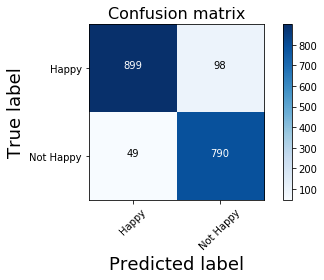

In [36]:
cm = confusion_matrix(all_targets,all_predicted)
plot_confusion_matrix(cm,class_names)